In [1]:
import math, random, os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

csv_path = os.path.join("data", "Students_Grading_Dataset.csv" )
dataset = pd.read_csv(csv_path)

In [2]:
dataset.columns

Index(['Student_ID', 'First_Name', 'Last_Name', 'Email', 'Gender', 'Age',
       'Department', 'Attendance (%)', 'Midterm_Score', 'Final_Score',
       'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score', 'Total_Score', 'Grade', 'Study_Hours_per_Week',
       'Extracurricular_Activities', 'Internet_Access_at_Home',
       'Parent_Education_Level', 'Family_Income_Level', 'Stress_Level (1-10)',
       'Sleep_Hours_per_Night'],
      dtype='object')

In [3]:
dataset_partial = dataset.drop([
    "Student_ID",
    "Midterm_Score",
    "Email", 
    "First_Name",
    "Last_Name", 
    "Midterm_Score", 
    "Projects_Score", 
    "Total_Score", 
    "Assignments_Avg", 
    "Participation_Score",
    "Quizzes_Avg", 
    "Projects_Score",
    "Attendance (%)"
], axis=1)


In [4]:
dataset_partial.head()

,Gender,Age,Department,Final_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,Female,22,Engineering,57.82,F,6.2,No,Yes,High School,Medium,5,4.7
1,Male,18,Engineering,45.80,A,19.0,No,Yes,NaN,Medium,4,9.0
2,Male,24,Business,93.68,D,20.7,No,Yes,Master's,Low,6,6.2
3,Female,24,Mathematics,80.63,A,24.8,Yes,Yes,High School,High,3,6.7
4,Female,23,CS,78.89,F,15.4,Yes,Yes,High School,High,2,7.1


In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset_partial, test_size=0.2, random_state=42)
dataset_partial = train_set.drop("Final_Score", axis=1)
dataset_partial_labels = train_set["Final_Score"].copy()

In [6]:
#dataset_partial_only_nums = dataset_partial.select_dtypes(exclude=['object'])
#corr_matrix = dataset_partial_only_nums.corr()
#corr_matrix["Final_Score"].sort_values(ascending=False)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

categorical_columns = [
    "Gender",
    "Department",
    "Grade", 
    "Extracurricular_Activities",
    "Internet_Access_at_Home",
    "Parent_Education_Level",
    "Family_Income_Level"
]
nums_columns = [
    "Study_Hours_per_Week",
    "Stress_Level (1-10)",
    "Sleep_Hours_per_Night",
    "Age"
]

cat_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
])

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, nums_columns),
    ("cat", cat_pipeline, categorical_columns),
])

dataset_prepared = full_pipeline.fit_transform(dataset_partial)
dataset_prepared

array([[-1.11293603, -1.23057586,  0.27697243, ...,  0.        ,
         1.        ,  0.        ],
       [-0.7407754 , -1.58099256, -1.64991198, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.80300203, -1.23057586, -0.27356597, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.36861477, -0.88015915, -0.61765247, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.15516686, -0.88015915,  0.20815513, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.74786712, -0.88015915, -0.13593137, ...,  0.        ,
         1.        ,  0.        ]], shape=(4000, 27))

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(dataset_prepared, dataset_partial_labels)

some_index = 5
some_data = dataset_partial[:some_index]
some_labels = dataset_partial_labels[:some_index]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [68.18029699 69.38325706 69.19652223 70.31809144 69.0934846 ]
Labels: [88.98, 90.03, 41.63, 86.43, 88.27]


In [13]:
from sklearn.metrics import mean_squared_error

dataset_prepared_predictions = lin_reg.predict(dataset_prepared)
lin_mse = mean_squared_error(dataset_partial_labels, dataset_prepared_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(17.233741660322487)

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(dataset_prepared, dataset_partial_labels)
tree_reg_predictions = tree_reg.predict(dataset_prepared)

In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, dataset_prepared, dataset_partial_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [24.06105051 25.61376319 24.19339821 24.5402124  25.15143888 24.65740258
 25.38286123 24.97305487 25.46866948 24.29840439]
Mean: 24.834025574604127
Standard deviation: 0.5333263868478363


In [17]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(dataset_prepared, dataset_partial_labels)
forest_reg_predictions = forest_reg.predict(dataset_prepared)

forest_scores = cross_val_score(forest_reg, dataset_prepared, dataset_partial_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [17.65438608 18.33803687 17.97822387 18.73840604 18.6931111  18.19759574
 18.64694587 18.24651329 18.90614451 18.76124364]
Mean: 18.416060701461983
Standard deviation: 0.380488515355548


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'bootstrap': [False], 'n_estimators': [60,100,200], 'max_features': [4,6,8,10]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(dataset_prepared, dataset_partial_labels)
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 100}

In [32]:
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = nums_columns + categorical_columns
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.2027690526437683), 'Study_Hours_per_Week'),
 (np.float64(0.1772686630973263), 'Sleep_Hours_per_Night'),
 (np.float64(0.11821820684665989), 'Stress_Level (1-10)'),
 (np.float64(0.09448630720998208), 'Age'),
 (np.float64(0.02067886476493608), 'Department'),
 (np.float64(0.020459074384493042), 'Gender'),
 (np.float64(0.0196164607227213), 'Internet_Access_at_Home'),
 (np.float64(0.019594257070465037), 'Family_Income_Level'),
 (np.float64(0.0176861944558474), 'Extracurricular_Activities'),
 (np.float64(0.01720392972926812), 'Grade'),
 (np.float64(0.014065917397743417), 'Parent_Education_Level')]

In [33]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("Final_Score", axis=1)
y_test = test_set["Final_Score"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(17.732676282257636)

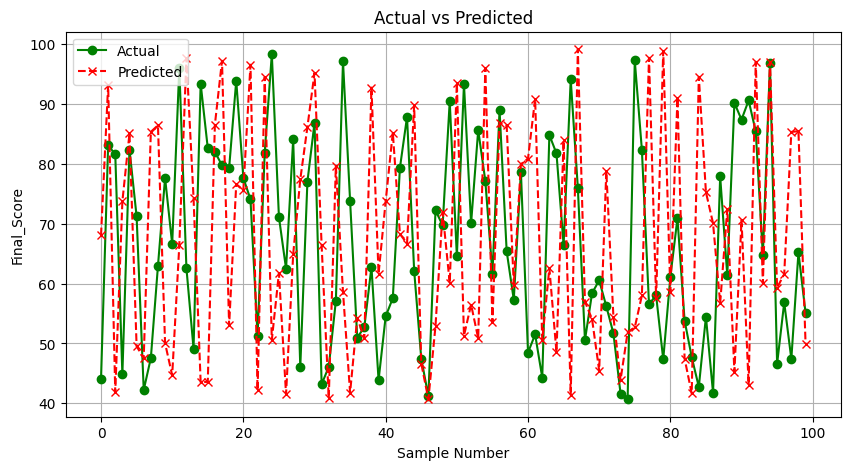

In [39]:
some_index_start = 0
some_index_end = 100

some_data = X_test[some_index_start:some_index_end]
some_labels = y_test[some_index_start:some_index_end]

some_data_prepared = full_pipeline.transform(some_data)

final_model = tree_reg
predictied_data = final_model.predict(some_data_prepared)
actual_data = list(some_labels)

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(actual_data, 'g-', marker='o', label='Actual')
plt.plot(predictied_data, 'r--', marker='x', label='Predicted')

# Add labels and title
plt.title('Actual vs Predicted')
plt.xlabel('Sample Number')
plt.ylabel('Final_Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()